[Paper](https://openreview.net/pdf?id=B17JTOe0-)

In [ ]:
import keras 
from keras import regularizers
from keras.layers import SimpleRNN, Dense, GaussianNoise
from keras.models import Sequential
import os
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')

dir = '/content/gdrive/My Drive/btp'
images_dir = '/content/gdrive/My Drive/btp/Images'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


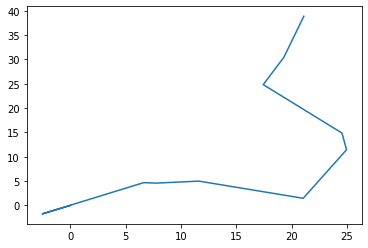

In [ ]:
def generate_input(path):
  
  input = []
  state = [0, 0]  
  for next_state in path:
    delta_y = next_state[1]-state[1]
    delta_x = next_state[0]-state[0]
    speed = ((delta_y)**2 + (delta_x)**2)**0.5
    direction = np.arctan2(delta_y,delta_x)
    input.append([speed,direction])
    state = next_state
  
  return input

N = 100000 # Number of data samples
max_step = 10
steps = 10
boundary = 50

input_set = []
output_set = []

for i in range(N):

  path = []
  for x in range(steps): 
    delta = list(np.random.uniform(-max_step,max_step,2))
    if x==0: path.append(delta)
    else: 
      while(True):
        a = path[x-1][0]+delta[0]
        b = path[x-1][1]+delta[1]
        if (a**2+b**2)**0.5 < boundary:
          path.append([a,b])
          break
        delta = list(np.random.uniform(-max_step,max_step,2))
        
      # path.append([max(min(path[x-1][0]+delta[0],boundary),-boundary),max(min(path[x-1][1]+delta[1],boundary),-boundary)])

  input = generate_input(path)
  
  input_set.append(input)
  output_set.append(path)

plt.plot([0]+[state[0] for state in output_set[0]], [0]+[state[1] for state in output_set[0]])
plt.show()


In [ ]:
model = Sequential()

model.add(SimpleRNN(100, input_shape=(steps,2), return_sequences=True, recurrent_regularizer='l2', activity_regularizer='l2'))
model.add(GaussianNoise(0.1))
model.add(Dense(2, activation='linear'))
model.compile(loss='mse')

# model.summary()

In [ ]:
xtrain = input_set[:int(0.8*len(input_set))]
ytrain = output_set[:int(0.8*len(output_set))]
xtest = input_set[int(0.8*len(input_set)):]
ytest = output_set[int(0.8*len(output_set)):]

In [ ]:
batch_size = 200
epochs = 50

model.summary()
model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(xtest, ytest))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 10, 100)           10300     
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 10, 100)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 10, 2)             202       
Total params: 10,502
Trainable params: 10,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
400/400 [==============================] - 10s 24ms/step - loss: 110.8978 - val_loss: 66.1972
Epoch 2/50
400/400 [==============================] - 6s 14ms/step - loss: 54.8217 - val_loss: 43.7578
Epoch 3/50
400/400 [==============================] - 6s 14ms/step - loss: 39.8493 - val_loss: 33.2118
Epoch 4/50
400/400 [==============================] - 6s 15ms/step - 

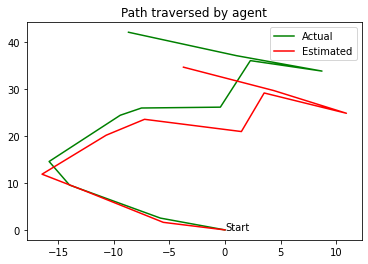

In [ ]:
instruction = xtest[-100]
path = ytest[-100]

estimate = model.predict([instruction])

plt.plot([0]+[state[0] for state in path], [0]+[state[1] for state in path], 'g')
plt.plot([0]+[state[0] for state in estimate[0]], [0]+[state[1] for state in estimate[0]], 'r')
plt.legend(['Actual', 'Estimated'])
plt.annotate('Start', (0,0))
plt.title("Path traversed by agent")
# plt.savefig(f"{images_dir}/path.png")
plt.show()

In [ ]:
weights = model.layers[0].get_weights()
model.save(f'{dir}/model_circ_{boundary}_{steps}.h5')

model2 = Sequential()
model2.add(SimpleRNN(100, input_shape=(steps,2), return_sequences=True, weights=weights))

In [ ]:
firing = {}
for h in range(100):
  firing[h] = {}

for instruction in xtest:
  estimate = model.predict([instruction])[0]
  representation = model2.predict([instruction])[0]
  for h in range(100):
    for i in range(steps):
      firing[h][tuple(estimate[i])] = representation[i][h]

In [ ]:
def heatmap2d(arr: np.ndarray, h):
    plt.imshow(arr, cmap='plasma')
    # plt.colorbar()
    plt.title(f'Hidden unit: {h}')
    plt.savefig(f"{images_dir}/circ/{h}.png")
    plt.show()


for h in range(100):
  arr = np.zeros((int(boundary*2.2),int(boundary*2.2)))
  # arr = -100*arr
  for key in firing[h].keys():
    arr[int(key[0]+boundary*1.1)][int(key[1]+boundary*1.1)] = firing[h][key]*10
  heatmap2d(arr, h)

Output hidden; open in https://colab.research.google.com to view.